# 3 DEVELOP

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

import sys
sys.path.insert(0, './modules')
from helpers import read_in_dataset, get_model_feature_importances, clf_performance

## 3.1 load the preprocessed data from files

In [2]:
X_train = read_in_dataset('X_train.csv', verbose = True)
X_test = read_in_dataset('X_test.csv', verbose = True)
test = read_in_dataset('data/test.csv')
Y_train = pd.read_csv('Y_train.csv',header=None)
Y_train.shape


***********************Reading in the X_train.csv dataset***********************

it has 891 rows and 40 columns

*************************it has the following columns
**************************
Index(['Age', 'Cabin_total', 'Parch', 'SibSp', 'norm_Fare',
       'Cabin_firstletter_A', 'Cabin_firstletter_B', 'Cabin_firstletter_C',
       'Cabin_firstletter_D', 'Cabin_firstletter_E', 'Cabin_firstletter_F',
       'Cabin_firstletter_G', 'Cabin_firstletter_T', 'Cabin_firstletter_n',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Ticket_firstletter_A',
       'Ticket_firstletter_C', 'Ticket_firstletter_F', 'Ticket_firstletter_L',
       'Ticket_firstletter_None', 'Ticket_firstletter_P',
       'Ticket_firstletter_S', 'Ticket_firstletter_W', 'name_title_adv_Col',
       'name_title_adv_Dr', 'name_title_adv_Major', 'name_title_adv_Master',
       'name_title_adv_Miss', 'name_title_adv_Mr', 'name_title_adv_Mrs',
       'na

(891, 1)

## 3.2 Try try different models using the default parameters
* naive bayes 0.4668
* Logistic regression 0.81933, turned to 0.8215
* tree 0.7924
* knn 0.8149, turned to 0.8249
* RandomForest, 0.81, turned to 0.8339, to 0.8372
* SVC, 0.8306, to 0.8350
* xgboost, 0.8305, turned to 0.8451

In [11]:
#Use Naive Bayes as a baseline
gnb = GaussianNB()
cv = cross_val_score(gnb, X_train, Y_train.values.ravel(), cv = 5)
print(cv)
print(cv.mean())

[0.53072626 0.46368715 0.45505618 0.41573034 0.46892655]
0.4668252956694957


In [14]:
lr = LogisticRegression(max_iter = 2000, solver='lbfgs')
cv = cross_val_score(lr, X_train, Y_train.values.ravel(), cv = 5)
print(cv)
print(cv.mean())

[0.82122905 0.82681564 0.78089888 0.81460674 0.85310734]
0.8193315310695454


In [15]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt, X_train, Y_train.values.ravel(), cv = 5)
print(cv)
print(cv.mean())

[0.7877095  0.78212291 0.83707865 0.76404494 0.79096045]
0.7923832899435312


In [16]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, X_train, Y_train.values.ravel(), cv = 5)
print(cv)
print(cv.mean())

[0.79888268 0.77094972 0.83707865 0.83146067 0.83615819]
0.8149059840335457


In [18]:
rf = RandomForestClassifier(random_state = 1, n_estimators = 10)
cv = cross_val_score(rf, X_train, Y_train.values.ravel(), cv = 5)
print(cv)
print(cv.mean())

[0.79329609 0.80446927 0.84269663 0.78089888 0.83615819]
0.8115038121673729


In [20]:
svc = SVC(probability = True, gamma = 'auto')
cv = cross_val_score(svc, X_train, Y_train.values.ravel(), cv = 5)
print(cv)
print(cv.mean())

[0.84357542 0.82681564 0.8258427  0.79213483 0.86440678]
0.8305550738406838


In [24]:
xgb = XGBClassifier(random_state = 1)
cv = cross_val_score(xgb, X_train, Y_train.values.ravel(), cv = 5)
print(cv)
print(cv.mean())

[0.82681564 0.82122905 0.86516854 0.82022472 0.81920904]
0.8305293981424839


In [26]:

voting_clf = VotingClassifier(estimators = [('gnb', gnb), ('lr', lr), ('dt', dt), ('knn', knn), ('rf', rf),  
                                            ('svc', svc), ('xgb', xgb)], voting = 'soft')

In [29]:
cv = cross_val_score(voting_clf, X_train, Y_train.values.ravel(), cv = 5)
print(cv)
print(cv.mean())

[0.82681564 0.81564246 0.84269663 0.80898876 0.83615819]
0.8260603371814963


In [39]:
voting_clf.fit(X_train, Y_train.values.ravel())
Y_hat_base_vc = voting_clf.predict(X_test).astype(int)
basic_submission = {'PassengerId': test.PassengerId, 'Survived': Y_hat_base_vc}
base_submission = pd.DataFrame(data = basic_submission)
base_submission.to_csv('base_submission.csv', index = False)

In [38]:
Y_hat_base_vc.dtype

dtype('int64')

## 3.4 Model Tuning

In [46]:
lr = LogisticRegression()
param_grid = {'max_iter': [2000],
             'penalty': ['l1', 'l2'],
             'C': np.logspace(-4, 4, 20),
             'solver': ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train, Y_train.values.ravel())
clf_performance(best_clf_lr, 'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Logistic Regression
Best Score: 0.8215488215488216
Best Parameters: {'C': 78.47599703514607, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.9s finished


In [47]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9],
             'weights': ['uniform', 'distance'],
             'algorithm': ['auto', 'ball_tree', 'kd_tree'],
             'p': [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train, Y_train.values.ravel())
clf_performance(best_clf_knn, 'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KNN
Best Score: 0.8249158249158249
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.9s finished


In [48]:
svc = SVC(probability = True)
param_grid = turned_parameters = [{'kernel': ['rbf'], 'gamma': [.1, .5, 1, 2, 5, 10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]}, 
                                 {'kernel': ['poly'], 'degree': [2, 3, 4, 5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train, Y_train.values.ravel())
clf_performance(best_clf_svc, 'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min


SVC
Best Score: 0.835016835016835
Best Parameters: {'C': 10, 'degree': 2, 'kernel': 'poly'}


[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  2.8min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [4]:
#use random search to narrow down the space for random forest
rf = RandomForestClassifier(random_state = 1)
param_grid = {'n_estimators': [100, 500, 1000],
             'bootstrap': [True, False],
             'max_depth': [3, 5, 10, 20, 50, 75, 100, None],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4, 10],
             'min_samples_split': [2, 5, 10]}
clf_rf = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train, Y_train.values.ravel())
clf_performance(best_clf_rf, 'Random Forest')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.6min finished


Random Forest
Best Score: 0.835016835016835
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 75, 'bootstrap': True}


In [51]:
rf = RandomForestClassifier(random_state = 1)
param_grid = {'n_estimators': [800, 900, 1000, 1100, 1200],
             'criterion': ['gini','entropy'],
             'bootstrap': [False],
             'max_depth': [15, 20, 25],
             'max_features': ['auto', 'sqrt', 10],
             'min_samples_leaf': [2, 3],
             'min_samples_split': [9, 10, 11]}
clf_rf = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train, Y_train.values.ravel())
clf_performance(best_clf_rf, 'Random Forest 2')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.4min finished


Random Forest 2
Best Score: 0.8372615039281706
Best Parameters: {'n_estimators': 900, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 25, 'criterion': 'entropy', 'bootstrap': False}


In [53]:
best_rf = best_clf_rf.best_estimator_.fit(X_train, Y_train.values.ravel())
feat_importances = pd.Series(best_rf.feature_importances_, index = X_train.columns)
feat_importances.nlargest(20).plot(kind = 'barh')

In [54]:
print(feat_importances.nlargest(20))

name_title_adv_Mr          0.134457
norm_Fare                  0.130868
Sex_male                   0.113910
Age                        0.110472
Sex_female                 0.106597
Pclass_3                   0.059647
SibSp                      0.041508
name_title_adv_Mrs         0.033677
Cabin_total                0.032582
Cabin_firstletter_n        0.029096
name_title_adv_Miss        0.028958
Pclass_1                   0.025715
Pclass_2                   0.021339
Parch                      0.020630
name_title_adv_Master      0.015554
Embarked_S                 0.011729
Ticket_firstletter_None    0.011040
Embarked_C                 0.010168
Ticket_firstletter_S       0.007420
Embarked_Q                 0.006616
dtype: float64


In [5]:
xgb = XGBClassifier(random_state = 1)
param_grid = {
    'n_estimators': [20, 50, 100, 250, 500, 1000],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'max_depth': [2, 5, 10, 15, 20, 25, None],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9],
    'learning_rate': [.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9],
    'gamma': [0, .01, .1, 1, 10, 100],
    'min_child_weight': [0, .01, .1, 1, 10, 100],
    'sampling_method': ['uniform']
}
clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 100, cv = 5, 
                                 verbose = True, n_jobs = -1)
best_clf_xgb_rnd = clf_xgb_rnd.fit(X_train, Y_train.values.ravel())
clf_performance(best_clf_xgb_rnd, 'XGB random')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 457 tasks      | elapsed:  1.7min


XGB random
Best Score: 0.8417508417508418
Best Parameters: {'subsample': 0.7, 'sampling_method': 'uniform', 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 0.01, 'max_depth': 10, 'learning_rate': 0.3, 'gamma': 0.01, 'colsample_bytree': 0.2}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [66]:
Y_hat_xgb_rnd = best_clf_xgb_rnd.best_estimator_.predict(X_test).astype(int)
xgb_rnd_submission = {'PassengerId': test.PassengerId, 'Survived': Y_hat_xgb_rnd}
submission_xgb_rnd = pd.DataFrame(data = xgb_rnd_submission)
submission_xgb_rnd.to_csv('xgb_rnd_submission.csv', index = False)

In [68]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb_rnd.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('knn', best_knn), ('rf', best_rf), ('svc', best_svc)], 
                                                 voting = 'hard')
voting_clf_soft = VotingClassifier(estimators = [('knn', best_knn), ('rf', best_rf), ('svc', best_svc)], 
                                                 voting = 'soft')
voting_clf_all = VotingClassifier(estimators = [('knn', best_knn), ('rf', best_rf), ('svc', best_svc), 
                                                ('lr', best_lr)], voting = 'soft')
voting_clf_xgb = VotingClassifier(estimators = [('knn', best_knn), ('rf', best_rf), ('svc', best_svc), 
                                                ('xgb', best_xgb),('lr', best_lr)], voting = 'soft')
print('voting_clf_hard: ', cross_val_score(voting_clf_hard, X_train, Y_train.values.ravel(), cv = 5))
print('voting_clf_hard mean: ', cross_val_score(voting_clf_hard, X_train, Y_train.values.ravel(), cv = 5).mean())

print('voting_clf_soft: ', cross_val_score(voting_clf_soft, X_train, Y_train.values.ravel(), cv = 5))
print('voting_clf_soft mean: ', cross_val_score(voting_clf_soft, X_train, Y_train.values.ravel(), cv = 5).mean())

print('voting_clf_all: ', cross_val_score(voting_clf_all, X_train, Y_train.values.ravel(), cv = 5))
print('voting_clf_all mean: ', cross_val_score(voting_clf_all, X_train, Y_train.values.ravel(), cv = 5).mean())

print('voting_clf_xgb: ', cross_val_score(voting_clf_xgb, X_train, Y_train.values.ravel(), cv = 5))
print('voting_clf_xgb mean: ', cross_val_score(voting_clf_xgb, X_train, Y_train.values.ravel(), cv = 5).mean())


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

voting_clf_hard:  [0.84357542 0.81564246 0.84269663 0.79775281 0.85310734]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

voting_clf_hard mean:  0.8305549319859976


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

voting_clf_soft:  [0.83798883 0.81564246 0.8258427  0.79775281 0.8700565 ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

voting_clf_soft mean:  0.830580253047482


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

voting_clf_all:  [0.83240223 0.81564246 0.84269663 0.79775281 0.8700565 ]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

voting_clf_all mean:  0.8317101256229638


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

voting_clf_xgb:  [0.83798883 0.82681564 0.84269663 0.79775281 0.87570621]


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarni

voting_clf_xgb mean:  0.8361920244330513


# 4. DEPLOY using the best model xgboost

In [6]:
#clf_xgb_rnd mean has the best estimate
Y_hat_xgb_rnd = best_clf_xgb_rnd.best_estimator_.predict(X_test).astype(int)
xgb_rnd_submission = {'PassengerId': test.PassengerId, 'Survived': Y_hat_xgb_rnd}
submission_xgb_rnd = pd.DataFrame(data = xgb_rnd_submission)
submission_xgb_rnd.to_csv('xgb_rnd_submission.csv', index = False)

In [8]:
best_clf_xgb_rnd = best_clf_xgb_rnd.best_estimator_.fit(X_train, Y_train.values.ravel())
feat_importances = pd.Series(best_clf_xgb_rnd.feature_importances_, index = X_train.columns)
feat_importances.nlargest(20).plot(kind = 'barh')

<AxesSubplot:>

In [9]:
print(feat_importances.nlargest(20))

Sex_male                 0.375361
name_title_adv_Master    0.078903
Pclass_3                 0.068306
Pclass_1                 0.029994
Sex_female               0.029295
norm_Fare                0.027792
Embarked_S               0.027290
SibSp                    0.020011
name_title_adv_Mr        0.019461
Age                      0.019317
Cabin_firstletter_G      0.018700
Pclass_2                 0.017393
name_title_adv_Miss      0.017327
Cabin_firstletter_C      0.017247
Embarked_C               0.016396
Cabin_firstletter_E      0.015445
Parch                    0.014998
Cabin_firstletter_n      0.014038
Ticket_firstletter_S     0.011664
Embarked_Q               0.011504
dtype: float32


<AxesSubplot:>

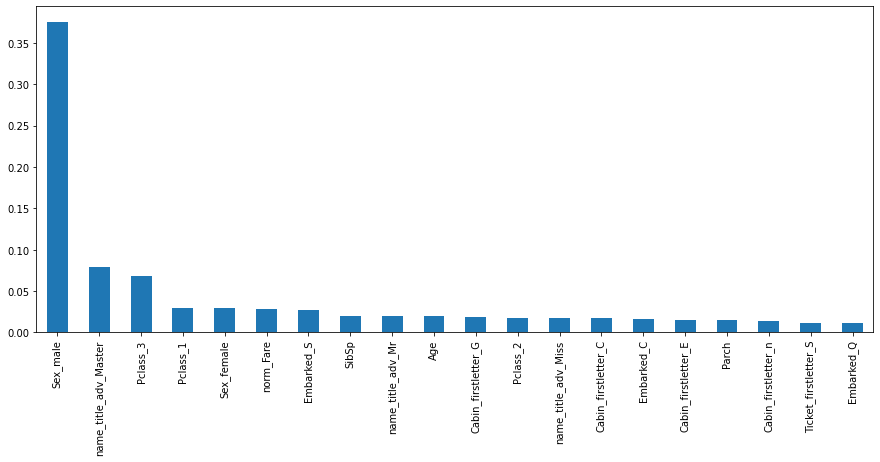

In [13]:
feat_importances.nlargest(20).plot(kind = 'bar', figsize = (15,6))